# Oxford Pilot. Four Motor Task (Right, Left, Arms, Legs). Dec 16th 2024

### My hope is to replicate the pre-processing Fieldtrip Pipeline I made

In [1]:
# We start by importing the relevant packages
import osl_ephys
import numpy as np
import mne
import glob
import yaml
import os
import matplotlib.pyplot as plt

# Set global font to Open Sans
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size'] = 12  # Adjust font size as desired


In [2]:
mne.__version__

'1.8.0'

In [38]:
%matplotlib qt

## Specify Subject

In [3]:
subject = 'seamus'

## Load in the Data

In [4]:
filename = 'BIDS/sub-{}/ses-001/meg/sub-{}_ses-001_task-fourMotor_run-001_meg.fif'.format(subject,subject)
# filename = 'sub-11766_ses-001_task-facescircles_run-001_meg.fif'
raw = mne.io.read_raw_fif(filename, preload=True)

Opening raw data file BIDS/sub-seamus/ses-001/meg/sub-seamus_ses-001_task-fourMotor_run-001_meg.fif...
    Range : 0 ... 2198783 =      0.000 ...  1465.855 secs
Ready.
Reading 0 ... 2198783  =      0.000 ...  1465.855 secs...


In [5]:
# Plot the sensors to check they are in the right orientation
fig = mne.viz.plot_alignment(raw.info,dig=True)

Using pyvistaqt 3d backend.
Getting helmet for system unknown (derived from 192 MEG channel locations)
Channel types::	mag: 192


In [6]:
# Plot the first 10s of raw data
raw.plot(highpass=2,
         lowpass=110.0,scalings = {'mag' : 1e-11},
         duration=10)
# plt.savefig('data_raw.png', dpi=300, bbox_inches='tight')

Setting up band-pass filter from 2 - 1.1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 110.00 Hz: -6.02, -6.02 dB

Using qt as 2D backend.
Using pyopengl with version 3.1.6


#### TO FIX: Can we substitute this with an anatomical layout

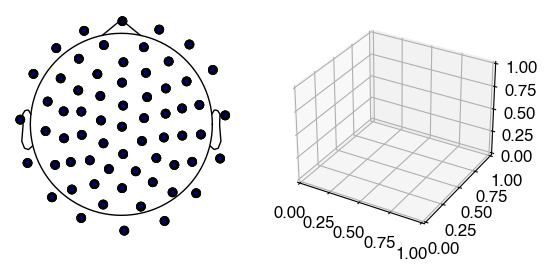

In [7]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection="3d")
raw.plot_sensors(ch_type="mag", axes=ax2d)
raw.plot_sensors(ch_type="mag", axes=ax3d, kind="3d")
ax3d.view_init(azim=70, elev=15)

## Add in channels we know are bad


In [8]:
# Add in channels we know are bad
import re

pattern = r'\b(H6|A3|G8) [XYZ]\b' # Modify accordingly 
matched_channels = [ch for ch in raw.info.ch_names if re.search(pattern, ch)]

raw.info['bads'].extend(matched_channels)


## Downsample to 300Hz

In [9]:
x = raw.copy().pick(picks=['mag'])
raw_downsampled = x.copy().resample(sfreq=300)


## Mark Bad Segments Based on Kurtosis

In [10]:
from osl_ephys.preprocessing.osl_wrappers import detect_badsegments

raw_downsampled = detect_badsegments(
    raw_downsampled,
    picks='mag',
    segment_len=300,
    significance_level=0.05,
    metric='kurtosis',
    channel_wise = False
)

In [42]:
import inter_plot
import importlib
importlib.reload(inter_plot)
from inter_plot import mark_bad_var

mark_bad_var(raw_downsampled)

APPLIED: 0.41% of the time marked as bad


In [33]:
raw_downsampled.plot(n_channels=5, scalings='auto',duration=100)


Using pyopengl with version 3.1.6


Channels marked as bad:
['F3 A3 Z', 'F3 A3 Y', 'F3 A3 X', 'T13 G8 Z', 'T13 G8 Y', 'T13 G8 X', 'T14 H6 Z', 'T14 H6 Y', 'T14 H6 X', 'P4 D3 Z']


## Plot the PSD

Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)
Plotting power spectral density (dB=True).


/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_31502/3948584183.py:6: UserWarning: Infinite value in PSD for channels T14 H6 Z, T14 H6 Y.
These channels might be dead.
  fig = psd.plot()  # This now returns a figure
/opt/anaconda3/envs/osl_OPM_ox/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


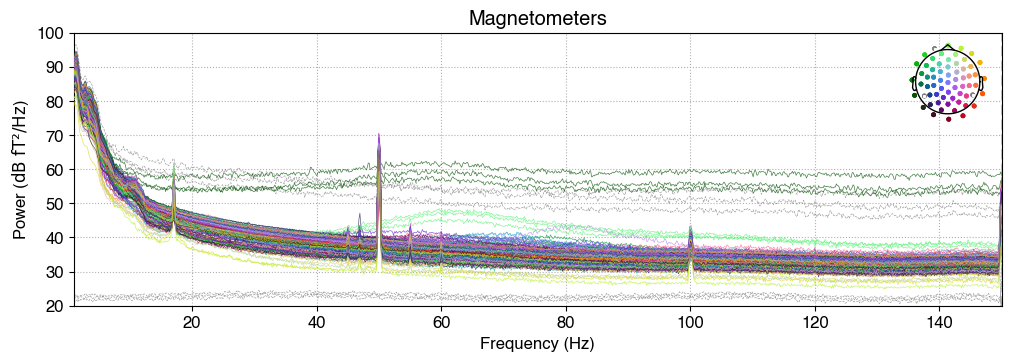

In [11]:
%matplotlib inline

psd = raw_downsampled.compute_psd(fmin=1, fmax=150, n_fft=2000,reject_by_annotation=True)

# Plot the PSD
fig = psd.plot()  # This now returns a figure

# Get the axis object from the figure
ax = fig.axes[0]  # Since psd.plot() returns an array, we need to index into the first axis

# # Set the y-axis limits
ax.set_ylim(20, 100)

plt.show()

## Detect Bad Chans from PSD

In [15]:
%matplotlib qt

import inter_plot
import importlib
importlib.reload(inter_plot)
from inter_plot import mark_bad_var
from inter_plot import plot_psd_with_alpha_slider

bad_channels = plot_psd_with_alpha_slider(raw_downsampled, initial_alpha=0.05,fmin=10,fmax=80)
print(bad_channels)

Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)
(183, 467)
[]


In [16]:
raw_downsampled.info['bads'].extend(bad_channels)
psd = raw_downsampled.compute_psd(fmin=1, fmax=150, n_fft=2000,reject_by_annotation=True)

# Plot the PSD
fig = psd.plot()  # This now returns a figure
# Get the axis object from the figure
ax = fig.axes[0]  # Since psd.plot() returns an array, we need to index into the first axis
# # Set the y-axis limits
ax.set_ylim(20, 100)
plt.show()


Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)
Plotting power spectral density (dB=True).


/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_31502/991676445.py:5: UserWarning: Infinite value in PSD for channels T14 H6 Z, T14 H6 Y.
These channels might be dead.
  fig = psd.plot()  # This now returns a figure


In [192]:
# Find Events From MNE Annotations

# Define a regex pattern for the desired annotations
pattern = '|'.join(['left_arm', 'left_leg', 'right_arm', 'right_leg'])

# Extract events with the regex pattern for annotation descriptions
events, event_ids = mne.events_from_annotations(raw_downsampled, regexp=pattern)

# Save the events array to a .npy file
np.save('events.npy', events)


Used Annotations descriptions: ['left_arm', 'left_leg', 'right_arm', 'right_leg']


array([[  2207,      0,      2],
       [  4559,      0,      2],
       [  6909,      0,      2],
       [  9288,      0,      4],
       [ 11616,      0,      2],
       [ 13890,      0,      4],
       [ 16160,      0,      1],
       [ 18448,      0,      4],
       [ 20830,      0,      2],
       [ 23166,      0,      3],
       [ 25524,      0,      2],
       [ 27924,      0,      1],
       [ 30285,      0,      2],
       [ 32656,      0,      4],
       [ 34998,      0,      4],
       [ 37380,      0,      4],
       [ 39714,      0,      3],
       [ 41988,      0,      3],
       [ 44379,      0,      2],
       [ 46766,      0,      4],
       [ 49095,      0,      1],
       [ 51369,      0,      3],
       [ 53707,      0,      4],
       [ 56051,      0,      1],
       [ 58409,      0,      1],
       [ 60783,      0,      3],
       [ 63134,      0,      1],
       [ 65496,      0,      1],
       [ 67749,      0,      1],
       [ 70107,      0,      3],
       [ 7

## Preprocess OPM Data

### HFC

In [18]:
# include gradients by setting order to 2, set to 1 for homgenous components
projs = mne.preprocessing.compute_proj_hfc(raw_downsampled.info, order=1)
raw_hfc1 = raw_downsampled.copy().add_proj(projs).apply_proj(verbose="error")
projs = mne.preprocessing.compute_proj_hfc(raw_downsampled.info, order=2)
raw_hfc2 = raw_downsampled.copy().add_proj(projs).apply_proj(verbose="error")

3 projection items deactivated
8 projection items deactivated


In [19]:
psd      = raw_downsampled.compute_psd(fmin=0,fmax=120,picks='mag',n_fft=2000)
psd_HFC1 = raw_hfc1.compute_psd(fmin=0,fmax=120,picks='mag',n_fft=2000)
psd_HFC2 = raw_hfc2.compute_psd(fmin=0,fmax=120,picks='mag',n_fft=2000)

Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)
Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)
Setting 1200 of 439757 (0.27%) samples to NaN, retaining 438557 (99.73%) samples.
Effective window size : 6.667 (s)


In [20]:
shielding = 10 * np.log10(psd[:] / psd_HFC1[:])

plot_kwargs = dict(lw=1, alpha=0.5)

plot_kwargs2 = {'lw': 4, 'alpha': 1, 'color': 'black'}

fig, ax = plt.subplots(layout="constrained")
ax.plot(psd.freqs, shielding.T, **plot_kwargs)
ax.plot(psd.freqs, shielding.mean(axis=0), **plot_kwargs2)
ax.grid(True, ls=":")
ax.set(
    xlim=(0, 120),
    title="Shielding After HFC",
    xlabel="Frequency (Hz)",
    ylabel="Shielding (dB)",
)
plt.savefig('shielding_HFC.png', dpi=300, bbox_inches='tight')

/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_31502/1001258107.py:1: RuntimeWarning: invalid value encountered in divide
  shielding = 10 * np.log10(psd[:] / psd_HFC1[:])


In [21]:
shielding = 10 * np.log10(psd[:] / psd_HFC2[:])

plot_kwargs = dict(lw=1, alpha=0.5)

plot_kwargs2 = {'lw': 4, 'alpha': 1, 'color': 'black'}

fig, ax = plt.subplots(layout="constrained")
ax.plot(psd.freqs, shielding.T, **plot_kwargs)
ax.plot(psd.freqs, shielding.mean(axis=0), **plot_kwargs2)
ax.grid(True, ls=":")
ax.set(
    xlim=(0, 120),
    title="Shielding After HFC + Gradient Term",
    xlabel="Frequency (Hz)",
    ylabel="Shielding (dB)",
)
plt.savefig('shielding_HFC_and_gradients.png', dpi=300, bbox_inches='tight')

/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_31502/2314806008.py:1: RuntimeWarning: invalid value encountered in divide
  shielding = 10 * np.log10(psd[:] / psd_HFC2[:])


In [22]:
shielding = 10 * np.log10(psd_HFC1[:] / psd_HFC2[:])

plot_kwargs = dict(lw=1, alpha=0.5)

plot_kwargs2 = {'lw': 4, 'alpha': 1, 'color': 'black'}

fig, ax = plt.subplots(layout="constrained")
ax.plot(psd.freqs, shielding.T, **plot_kwargs)
ax.plot(psd.freqs, shielding.mean(axis=0), **plot_kwargs2)
ax.grid(True, ls=":")
ax.set(
    xlim=(0, 120),
    title="Effect of Adding in Gradient Term",
    xlabel="Frequency (Hz)",
    ylabel="Shielding (dB)",
)
plt.savefig('gradient_term_HFC.png', dpi=300, bbox_inches='tight')

/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_31502/1192187171.py:1: RuntimeWarning: invalid value encountered in divide
  shielding = 10 * np.log10(psd_HFC1[:] / psd_HFC2[:])


### BP and Notch Filter

In [23]:
# BP Filter
raw_bp = raw_hfc2.copy().filter(l_freq=2, h_freq=50)

# Notch Filter
freqs = (50, 100)
raw_notch = raw_bp.copy().notch_filter(freqs=freqs, picks='mag',notch_widths=2)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 495 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1981 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.9s


## Save the Intermediate Data

In [24]:
# Define the directory path where you want to save the file
output_dir = 'BIDS/derivatives/preprocessing/sub-{}/ses-001/meg'.format(subject)
output_file = 'sub-{}_ses-001_task-fourMotor_run-001_preICA.fif'.format(subject)

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# # Save the clean data
raw_notch.save(os.path.join(output_dir, output_file),overwrite=True)

Overwriting existing file.
Writing /Users/robertseymour/data/20241216_oxford_pilot/BIDS/derivatives/preprocessing/sub-seamus/ses-001/meg/sub-seamus_ses-001_task-fourMotor_run-001_preICA.fif


/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_31502/1771163706.py:9: RuntimeWarning: This filename (/Users/robertseymour/data/20241216_oxford_pilot/BIDS/derivatives/preprocessing/sub-seamus/ses-001/meg/sub-seamus_ses-001_task-fourMotor_run-001_preICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_notch.save(os.path.join(output_dir, output_file),overwrite=True)


Closing /Users/robertseymour/data/20241216_oxford_pilot/BIDS/derivatives/preprocessing/sub-seamus/ses-001/meg/sub-seamus_ses-001_task-fourMotor_run-001_preICA.fif
[done]


## ICA

In [ ]:
import mne
from mne.preprocessing import ICA
from mne.viz import plot_topomap
import numpy as np

# Compute ICA on all channels (use raw_notch as input)
ica = ICA(n_components=60, random_state=97, max_iter=800,method='picard')
ica.fit(raw_notch)  # Fit ICA on all channels


Fitting ICA to data using 178 channels (please be patient, this may take a while)
Omitting 1200 of 439757 (0.27%) samples, retaining 438557 (99.73%) samples.
    Applying projection operator with 8 vectors (pre-whitener computation)
    Applying projection operator with 8 vectors (pre-whitener application)
Selecting by number: 60 components
    Applying projection operator with 8 vectors (pre-whitener application)
Fitting ICA took 123.2s.


Method,picard
Fit parameters,max_iter=800
Fit,163 iterations on raw data (438557 samples)
ICA components,60
Available PCA components,178
Channel types,mag
ICA components marked for exclusion,—


In [ ]:
ica.plot_sources(raw, show_scrollbars=False)

In [141]:
import matplotlib.pyplot as plt
import mne
from mne.viz import plot_topomap
import math

def plot_ica_topomaps_Z(raw_notch, ica, batch_size=10, colormap='RdBu_r'):
    """
    Plot ICA components as topomaps for selected good Z channels, displaying them in batches.

    This function creates a series of topomap plots of ICA components for channels that match a 
    regular expression (those ending in "Z"), excluding bad channels, and plots them in batches. 
    The user can specify the number of components to display in each batch, and the colormap for 
    visualizing the topomaps.

    Parameters
    ----------
    raw_notch : mne.io.Raw
        Raw MEG data containing all channels. Channels matching the regex pattern ".*Z$" will be 
        selected, excluding bad channels.
    ica : mne.preprocessing.ICA
        The ICA object containing the computed ICA components.
    batch_size : int, optional
        The number of components to plot in each batch (as subplots). Default is 10.
    colormap : str, optional
        The colormap to use for plotting the topomaps. Default is 'RdBu_r'.

    Returns
    -------
    None
        The function directly displays the topomap plots in subplots, with each subplot showing one 
        ICA component. The components are grouped in batches of the specified size.
    
    Notes
    -----
    - The function first identifies channels ending with "Z" and that are not marked as bad in 
      the raw data.
    - The ICA components corresponding to the good channels are extracted and displayed as 
      topomaps.
    - The topomaps are displayed in batches of the specified size.
    """
    # Get good channels
    all_channels = raw_notch.info['ch_names']
    bad_channels = raw_notch.info['bads']
    good_channels = [ch for ch in all_channels if ch not in bad_channels]

    # Get channels matching the regex pattern
    Z_picks = mne.pick_channels_regexp(all_channels, regexp=r".*Z$")  # Indices of channels ending in "Z"
    Z_channels = [all_channels[i] for i in Z_picks]  # Get channel names ending in "Z"

    # Combine with good channels
    Z_good_channels = [ch for ch in Z_channels if ch in good_channels]

    # Get the indices of the combined good channels in raw_notch
    Z_good_picks = [all_channels.index(ch) for ch in Z_good_channels]

    # Select the good Z channels from raw_notch
    raw_notch_Z = raw_notch.copy().pick(Z_good_channels, exclude="bads")

    # Get the ICA channel names
    ica_channels = ica.info['ch_names']

    # Find the indices of Z_good_channels in ICA channels
    Z_good_ica_picks = [ica_channels.index(ch) for ch in Z_good_channels]

    # Get the ICA components (all components)
    ica_data = ica.get_components()

    # Determine the number of components
    num_components = ica.n_components_

    # Loop through all components in batches
    for i in range(0, num_components, batch_size):  # Loop in steps of batch_size
        # Calculate the number of subplots required (rows and columns)
        num_subplots = min(batch_size, num_components - i)
        rows = int(math.ceil(num_subplots / 5))  # Keep 5 columns
        cols = 5
        
        # Create a subplot grid
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))  # Adjust height based on rows
        axes = axes.ravel()  # Flatten the axes array to make indexing easier
        
        # Plot the components for the current batch
        for comp in range(i, min(i + batch_size, num_components)):  # Loop through the components in the batch
            comp_data = ica_data[Z_good_ica_picks, comp]  # Get the data for the component
            ax = axes[comp - i]  # Get the current axis
            plot_topomap(comp_data, raw_notch_Z.info, axes=ax, show=False, size=3, cmap=colormap)  # Plot on the current axis
            ax.set_title(f'COMP: {comp}')  # Title for each subplot
        
        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

# Example of usage:
# plot_ica_topomaps_Z(raw_notch, ica, batch_size=10, colormap='viridis')


In [148]:
plot_ica_topomaps_Z(raw_notch, ica, batch_size=20, colormap='turbo')


In [146]:
# # # Use OSL's ICA databrowser to make corrections where needed
# from osl_ephys.preprocessing.plot_ica import plot_ica
# fig = plot_ica(ica, raw_notch)
# fig.set_size_inches(10,8)

# # Run this cell when you're done in the interactive figure.
# fig._close(1)

# print(f'The following components were labeled as bad: {ica.exclude}')
# print(f'These are the contents of ica.labels_: {ica.labels_}')

In [149]:
ica.exclude = [41,46]  # indices chosen based on various plots above

In [150]:
# # Remove bad components from the data
clean = ica.apply(raw_notch.copy())

Applying ICA to Raw instance
    Applying projection operator with 8 vectors (pre-whitener application)
    Transforming to ICA space (60 components)
    Zeroing out 2 ICA components
    Projecting back using 178 PCA components


In [161]:
Z_picks = mne.pick_channels_regexp(clean.info['ch_names'], regexp=r".*Z$")
clean.plot(start=20,duration=10,picks=Z_picks,n_channels=64,
           butterfly=False,scalings = {'mag' : 1e-12})
# plt.savefig('clean_plot.png', dpi=300, bbox_inches='tight')

Using pyopengl with version 3.1.6


## Save the Clean Data

In [162]:
# Define the directory path where you want to save the file
output_dir = 'BIDS/derivatives/preprocessing/sub-{}/ses-001/meg'.format(subject)
output_file = 'sub-{}_ses-001_task-fourMotor_run-001_clean.fif'.format(subject)

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# # Save the clean data
clean.save(os.path.join(output_dir, output_file),overwrite=True)


Overwriting existing file.
Writing /Users/robertseymour/data/20241216_oxford_pilot/BIDS/derivatives/preprocessing/sub-seamus/ses-001/meg/sub-seamus_ses-001_task-fourMotor_run-001_clean.fif


/var/folders/lc/2w90j0s17cx3s8fl2m6h2gz80000gn/T/ipykernel_31502/29900717.py:9: RuntimeWarning: This filename (/Users/robertseymour/data/20241216_oxford_pilot/BIDS/derivatives/preprocessing/sub-seamus/ses-001/meg/sub-seamus_ses-001_task-fourMotor_run-001_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  clean.save(os.path.join(output_dir, output_file),overwrite=True)


Closing /Users/robertseymour/data/20241216_oxford_pilot/BIDS/derivatives/preprocessing/sub-seamus/ses-001/meg/sub-seamus_ses-001_task-fourMotor_run-001_clean.fif
[done]
